In [51]:
import wave
import pyaudio
from groq import Groq
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Optional, Union
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain.messages import SystemMessage, HumanMessage
from IPython.display import Image, display

class State(TypedDict):
    audio_wav: Optional[str]
    text: Optional[str]
    product_list: List[dict]
    is_running: bool

In [ ]:
def record_audio_note(state: State) -> State:
    """ air vibration -> microphone -> numbers -> files 
        used to record the users requirements
    """
    
    if not state['is_running']:
        return state
    
    # each sample ranges(16 bit integer) -32768 to 32768 represents air pressure moment at a time
    format = pyaudio.paInt16
    # singe microphone 
    channel = 1
    # 16000(standard, 44100 music quality) (hz) samples per sec - each sample repreent how loud sound is at exact moment
    rate = 16000
    # read 1024 sampls from mic starting (16000 samples per sec but not in one shot split into blocks and each block having 1024 sample to avoid the overhead)
    chunk = 1024
    # num of sec to record 
    record_second = 15
    # file name
    wave_output_filename = "temp_audio.wav"
    
    audio = pyaudio.PyAudio()
    
    stream = audio.open(
        format=format,
        channels=channel,
        rate=rate,
        input=True,
        frames_per_buffer=chunk
    )
    
    frames = []
    # calculate how many blocks required (chunks)
    for i in range(0,int(rate/chunk*record_second)):
        data = stream.read(chunk)
        frames.append(data)
        
    stream.start_stream()
    stream.close()
    audio.terminate()
    
    
    with wave.open(wave_output_filename, 'wb') as wf:
        wf.setnchannels(channel)
        # byte per sample
        wf.setsampwidth(audio.get_sample_size(format))
        # play 16000 sample per sec
        wf.setframerate(rate)
        # wav expect continuous byte stream (writing wav with instruction)
        wf.writeframes(b''.join(frames))
    
    
    print("audio is saved")
    
    return {**state, "audio_wav":wave_output_filename}        
    
    

In [4]:
from dotenv import load_dotenv
import os
load_dotenv(override=True)
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [5]:
def voice_to_text_node(state:State) -> State:
    """Converting the audio to text using the groq asr(automatic speech regonisation) model"""
    if not state['audio_wav']:
        return {**state,"text":""}
    
    client = Groq()
    
    with open(state['audio_wav'],'rb') as file:
        transcription =client.audio.transcriptions.create(
            file=file,
            model="whisper-large-v3",
            response_format='json'
        )
        
    text = transcription.text or ""
    print(text)
    return {**state,"text":text}

In [16]:
class Product(BaseModel):
    name: str = Field(
        description="Product name in ENGLISH only. Must be translated from the user's language if needed."
    )
    quantity: float = Field(
        description="Quantity as a number, using ENGLISH units"
    )
    unit: str = Field(description="kg, g, litre, ml, piece, pack must be string if user says in units in tamil must be convert into english e.g -> kilo=kilogram(expected kg)")
    
class ProductList(BaseModel):
    products : List[Product] = Field(description="List of extracted product")

In [17]:
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0.7
)

In [44]:
def extract_product_node(state:State) -> State:
    if not state['text'].strip():
        print("Text is empty")
        return {**state, "product_list":[]}
    
    system_prompt = (
    "You are a product information extraction assistant.\n"
    "The user may speak in any language (Tamil, Telugu, Hindi, etc.), but:\n"
    "- ALL extracted product names MUST be translated into ENGLISH.\n"
    "- ALL field values (name, price, quantity) MUST be in ENGLISH.\n"
    "- Do NOT return product names in any other language or script.\n"
    "- If a product name is unclear, translate it to the closest common English name.\n"
    "Return the output strictly according to the attached schema.\n"
    "If no product is mentioned, return an empty list."
)

    
    user_prompt = (
        f"Extract the product details from the following utterance : \n\n {state['text']}"
    )
    
    structured_llm = llm.with_structured_output(ProductList)
    
    result = structured_llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])
    
    return {**state, "product_list": result.products}

In [45]:
def should_continue(state:State) -> str:
    if not state['is_running']:
        return "end"
    if len(state['product_list'])>0:
        return "end"

    return "record"

In [46]:
workflow = StateGraph(State)

workflow.add_node("record", record_audio_note)
workflow.add_node("voice_to_text", voice_to_text_node)
workflow.add_node("extract_products", extract_product_node)

workflow.set_entry_point("record")

workflow.add_edge("record", "voice_to_text")
workflow.add_edge("voice_to_text", "extract_products")
workflow.add_edge("extract_products", END)

app = workflow.compile()


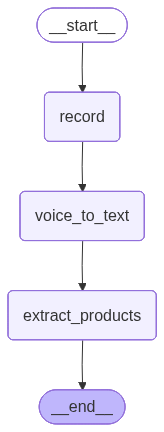

In [53]:
display(Image(app.get_graph().draw_mermaid_png()))

In [49]:
initial_state = State(
    audio_wav=None,
    text=None,
    product_list=[],
    is_running=True,
)

try:
    final_state = app.invoke(initial_state)
    print("\nFinal product list (English):")
    for p in final_state["product_list"]:
        print("- Name:", p.name)
        print("  Quantity:", p.quantity)
        print("  Unit:",p.unit)
except KeyboardInterrupt:
    print("\n Stopped by user")


audio is saved
 ஒரு கிலோ உளுத்தம் பருப்பு, ஒரு கிலோ பாசி பருப்பு, ஒரு தேங்காய், ஒரு அரசன் ப்ளூ சோக், நூரு கிரம் வெந்தயம், நூரு கிரம் கடுகி.

Final product list (English):
- Name: Urad dal
  Quantity: 1.0
  Unit: kg
- Name: Moong dal
  Quantity: 1.0
  Unit: kg
- Name: Coconut
  Quantity: 1.0
  Unit: piece
- Name: Arasan Blue Sock
  Quantity: 1.0
  Unit: piece
- Name: Fenugreek seeds
  Quantity: 100.0
  Unit: g
- Name: Mustard seeds
  Quantity: 100.0
  Unit: g
